## EyePacs1K Inception Pretrained

The code is based on [FINETUNING TORCHVISION MODELS](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#inception-v3).

See this [Design Doc](https://www.notion.so/Design-Doc-Models-for-1K-EyePacs-dataset-9574c996415849e1beea9674371a28d9#f5ff7957d4674a27a1971d7899e2572f) for discussion on the design decisions made.




In [1]:
from sklearn.model_selection import train_test_split
import torch
import torchvision
import pandas as pd
import os
import random
from torch.utils.data import DataLoader, Dataset
import json
import ast
from torchvision import transforms
from PIL import Image
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from helper_functions import moderate_dr_plus, vtdr, dr_nodr, split_eyes_to_lists, split_eyes, initialize_model
from helper_functions import explode_dataset_per_eye, EyePacs1KDataset, get_mean_std, calc_precision_recall_stats, show_frozen_weights
from helper_functions import freeze_unfreeze_all_base_weights, train_model, unfreeze_final_layer_classifier_weights 
from helper_functions import dataset_images_root, dataset_csv_root
from helper_functions import show_pytorch_image_grid, renormalize_image, undersample
import wandb
from helper_functions import CustomRescaleTransform
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117


## Auto-reload

In [2]:
%load_ext autoreload
%autoreload 2

## Wandb login

In [3]:
# Log in to your W&B account
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tleyden (eyepi). Use `wandb login --relogin` to force relogin


True

## Load preprocessed dataset csv

See EyePacs1k_EDA.ipynb for details on preprocessing

In [4]:
dataset_csv = os.path.join(dataset_csv_root, "dataset_preprocessed.csv")
df = pd.read_csv(dataset_csv)
df

Unnamed: 0  case_id  age_at_encounter gender                ethnicity  \
0              0  1470916                47      F           Latin American   
1              1  1470912                40      M           Latin American   
2              2  1470880                21      F           Latin American   
3              3  1470853                44      N  ethnicity not specified   
4              4  1470702                45      N  ethnicity not specified   
...          ...      ...               ...    ...                      ...   
1093        1262   569019                38      M  ethnicity not specified   
1094        1263   560798                33      M  ethnicity not specified   
1095        1264   559463                66      F           Latin American   
1096        1265   546702                40      M           Latin American   
1097        1267   523593                29      M           Latin American   

     years_with_diabetes  hba1c  cholesterol  triglycerides  \
0         1 year or less    6.2          203          266.0   
1                4 years    6.1          223          326.0   
2                2 years    9.2          165          111.0   
3            16-20 years   11.1          242          166.0   
4         1 year or less    7.0          151          113.0   
...                  ...    ...          ...            ...   
1093          6-10 years    5.6          178           32.0   
1094      1 year or less    5.5          155          150.0   
1095             2 years    5.2          164          101.0   
1096          6-10 years    5.4          133           79.0   
1097             2 years    5.6          138          264.0   

             pupil_dilation  ...      dr_level_lft  dme_lft cataract glaucoma  \
0             not necessary  ...             No DR  No CSME      NaN      NaN   
1             not necessary  ...             No DR  No CSME      NaN      NaN   
2             not necessary  ...             No DR  No CSME      NaN      NaN   
3             not necessary  ...     Moderate NPDR  No CSME      NaN      NaN   
4             not necessary  ...             No DR  No CSME      NaN      NaN   
...                     ...  ...               ...      ...      ...      ...   
1093  1 gtt. tropicamide 1%  ...        Ungradable     CSME      NaN      NaN   
1094          not necessary  ...           Mild DR  No CSME      NaN      NaN   
1095  1 gtt. tropicamide 1%  ...  Proliferative DR  No CSME      NaN      NaN   
1096  1 gtt. tropicamide 1%  ...             No DR  No CSME      NaN      NaN   
1097          not necessary  ...             No DR  No CSME      NaN      NaN   

     occlusion maculopathy             camera  \
0          NaN         NaN  Crystalvue NFC700   
1          NaN         NaN  Crystalvue NFC700   
2          NaN         NaN          Canon CR2   
3          NaN         NaN  Crystalvue NFC700   
4          NaN         NaN  Crystalvue NFC700   
...        ...         ...                ...   
1093       NaN         NaN          Canon CR2   
1094       NaN         NaN          Canon DGi   
1095       NaN         NaN       CR1_Canon_na   
1096       NaN         NaN          Canon CR2   
1097       NaN         NaN          Canon Dgi   

                                    eye_image_filenames  \
0     ['EyePacs1KDataset/587_587_resized_images/1021...   
1     ['EyePacs1KDataset/587_587_resized_images/1021...   
2     ['EyePacs1KDataset/587_587_resized_images/8668...   
3     ['EyePacs1KDataset/587_587_resized_images/1021...   
4     ['EyePacs1KDataset/587_587_resized_images/1021...   
...                                                 ...   
1093  ['EyePacs1KDataset/587_587_resized_images/5262...   
1094  ['EyePacs1KDataset/587_587_resized_images/4004...   
1095  ['EyePacs1KDataset/587_587_resized_images/3994...   
1096  ['EyePacs1KDataset/587_587_resized_images/3873...   
1097  ['EyePacs1KDataset/587_587_resized_images/3699...   

     num_eye_image_filenames 

## Hyperparams / globals

In [5]:
model_name = "resnet_fc2"  # valid model names: inception, resnet (resnet18), resnet52, vgg 

# Target binary classification label to train on
target_label = "dr_nodr"  # other valid target labels: moderate_dr_plus, vtdr

# Set a random seed for reproducibility
random_seed = 40
random.seed(random_seed)

# Number of epochs to train for
num_epochs = 200

# The nature paper uses 587x587, but the inception network was trained on 299x299 images.  
# This needs some experimentation to find the best value.
if model_name == "inception":
    input_size = 299
elif model_name.startswith("resnet"):
    input_size = 224
else:
    raise Exception("Unknown model name")

# Determine the batch size based on the input size
if input_size == 299:
    batch_size = 32  # Higher batch size fits in gpu memory, but there are other bottlenecks that limit the speed
elif input_size == 224:
    # One risk of lowering the batch size: it may hit this error when calculating the ROC AUC score:
    # roc_auc_score - Only one class present in y_true(https://stackoverflow.com/questions/45139163/roc-auc-score-only-one-class-present-in-y-true)
    batch_size = 32
elif input_size == 587:
    # Fits on 8GB GPU with image size of 587x587
    batch_size = 16
else:
    raise Exception("Unknown input size")

# TODO: review this to match the paper
lr = 0.0001

# TODO: review this to match the paper
# Note: not used, currently using AdamW optimizer instead of SGD
momentum = 0.9

# This is the dropout rate used in the nature paper.
# NOTE: only used with inception model, ignored for other models
final_dropout = 0.2

# Number of classes in the dataset
num_classes = 1

# Flag for feature extracting. 
# True: Only train the classifier weights.
# False: Unfreeze and train some/all CNN layers in addition to classifier weights
feature_extract = True

# Reduce this to run experiments faster on a subset of the dataset
percent_of_dataset_to_use = 1.0

# Training set mean and stddev.  Use ImageNet values since that what the
# pre-trained weights were trained on.
training_image_mean = [0.485, 0.456, 0.406]
training_image_std = [0.229, 0.224, 0.225]

# Use an LR scheduler?
use_learning_rate_scheduler = True

# After this many steps, the LR will be reduced by a factor of lr_gamma
lr_step_size = 50
if use_learning_rate_scheduler:
    # If use_learning_rate_scheduler is false, short-circuit the LR scheduler 
    lr_gamma = 0.5
else:
    lr_gamma = 1.0

# When feature_extract is false and fine-tuning is enabled, this flag controls which backbone weights are unfrozen
# If true, it will unfreeze all weights in the network.
# If false, it will only unfreeze the final layer CNN layer and classifier weights
freeze_unfreeze_all_base_weights_flag = False

# If true, it will use a different learning rate.  It will use a higher learning rate for the classifier
# head weights, and a lower learning rate as you go deeper into the network towards the input layer.
use_differential_learning_rate = False

# Augmentation parameters (if the augmentation is enabled)
cutout_num_holes=4
cutout_max_h_size=16
cutout_max_w_size=16
cutout_prob=0.5

# Adamw optimizer L2 regularization weight decay
adamw_weight_decay = 1e-2

add_regularization_augmentations = True

# Number of folds for k-folds cross validation. Set to 1 to disable k-folds cross validation
num_folds = 1

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# If true, will understample exploded datasets to balance the number of samples per class
balance_labels_by_under_sampling = False

## Stratified train/test split

In [6]:
train_dfs_by_fold = []
validation_dfs_by_fold = []

# StratifiedKFold uses an 80/20 split for train/test by default
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
for fold_index, (train_index, test_index) in enumerate(skf.split(df, df["dr_level_rt"])):
    print(f"Fold {fold_index} train index: {len(train_index)} test index: {len(test_index)}")
    train_df_fold = df.iloc[train_index]
    train_dfs_by_fold.append(train_df_fold)
    validation_df_fold = df.iloc[test_index]
    validation_dfs_by_fold.append(validation_df_fold)

Fold 0 train index: 878 test index: 220
Fold 1 train index: 878 test index: 220
Fold 2 train index: 878 test index: 220
Fold 3 train index: 879 test index: 219
Fold 4 train index: 879 test index: 219


## Take subset of dataset

In [7]:
if percent_of_dataset_to_use < 1.0:
    for fold_index in range(num_folds):
        
        train_df = train_dfs_by_fold[fold_index]
        train_df = train_df.sample(frac=percent_of_dataset_to_use)
        train_dfs_by_fold[fold_index] = train_df

        validation_df = validation_dfs_by_fold[fold_index]
        validation_df = validation_df.sample(frac=percent_of_dataset_to_use)
        validation_dfs_by_fold[fold_index] = validation_df


## Explode dataset: create a row per left and right input image

This must happen *after* the train/validation/test split, because we don't want a single case to cross over into the different splits.

Also:

* filter out any images with dr_level marked as ungradable since they are not useful for training
* Add diabetic retinopathy metalabels

See this [design doc](https://www.notion.so/Design-Doc-Models-for-1K-EyePacs-dataset-9574c996415849e1beea9674371a28d9#f5ff7957d4674a27a1971d7899e2572f) for details.



In [8]:
train_df_exploded_per_fold = []
validation_df_exploded_per_fold = []

for fold_index in range(num_folds):
    train_df = train_dfs_by_fold[fold_index]
    train_df_exploded = explode_dataset_per_eye(train_df)
    if balance_labels_by_under_sampling:
        train_df_exploded = undersample(train_df_exploded, "dr_nodr", True)
    train_df_exploded_per_fold.append(train_df_exploded)

    validation_df = validation_dfs_by_fold[fold_index]
    validation_df_exploded = explode_dataset_per_eye(validation_df)
    if balance_labels_by_under_sampling:
        validation_df_exploded = undersample(validation_df_exploded, "dr_nodr", True)
    validation_df_exploded_per_fold.append(validation_df_exploded)


## Balance dataset by undersampling overrepresented class

In [9]:
train_df_exploded_per_fold[0]

case_id                                         image_path  \
0     1470916  EyePacs1KDataset/587_587_resized_images/102114...   
1     1470916  EyePacs1KDataset/587_587_resized_images/102114...   
2     1470912  EyePacs1KDataset/587_587_resized_images/102114...   
3     1470912  EyePacs1KDataset/587_587_resized_images/102114...   
4     1470853  EyePacs1KDataset/587_587_resized_images/102110...   
...       ...                                                ...   
1667   560798  EyePacs1KDataset/587_587_resized_images/400432...   
1668   559463  EyePacs1KDataset/587_587_resized_images/399421...   
1669   559463  EyePacs1KDataset/587_587_resized_images/399421...   
1670   523593  EyePacs1KDataset/587_587_resized_images/369955...   
1671   523593  EyePacs1KDataset/587_587_resized_images/369955...   

     left_or_right_eye          dr_level      dme  moderate_dr_plus   vtdr  \
0                  lft             No DR  No CSME             False  False   
1                  lft             No DR  No CSME             False  False   
2                  lft             No DR  No CSME             False  False   
3                  lft             No DR  No CSME             False  False   
4                  lft     Moderate NPDR  No CSME              True  False   
...                ...               ...      ...               ...    ...   
1667                rt     Moderate NPDR  No CSME              True  False   
1668               lft  Proliferative DR  No CSME              True   True   
1669                rt  Proliferative DR  No CSME              True   True   
1670               lft             No DR  No CSME             False  False   
1671                rt     Moderate NPDR  No CSME              True  False   

      dr_nodr  left_right_dr_mismatch  
0       False                   False  
1       False                   False  
2       False                   False  
3       False                   False  
4        True                   False  
...       ...                     ...  
1667     True                    True  
1668     True                   False  
1669     True                   False  
1670    False                    True  
1671     True                    True  

[1672 rows x 9 columns]

In [10]:
validation_df_exploded_per_fold[0]

case_id                                         image_path  \
0    1470880  EyePacs1KDataset/587_587_resized_images/866830...   
1    1470880  EyePacs1KDataset/587_587_resized_images/866830...   
2    1470603  EyePacs1KDataset/587_587_resized_images/868276...   
3    1470603  EyePacs1KDataset/587_587_resized_images/868276...   
4    1470336  EyePacs1KDataset/587_587_resized_images/102079...   
..       ...                                                ...   
411   690721  EyePacs1KDataset/587_587_resized_images/431896...   
412   639001  EyePacs1KDataset/587_587_resized_images/461514...   
413   639001  EyePacs1KDataset/587_587_resized_images/461514...   
414   546702  EyePacs1KDataset/587_587_resized_images/387357...   
415   546702  EyePacs1KDataset/587_587_resized_images/387357...   

    left_or_right_eye       dr_level      dme  moderate_dr_plus   vtdr  \
0                 lft          No DR  No CSME             False  False   
1                  rt          No DR  No CSME             False  False   
2                 lft          No DR  No CSME             False  False   
3                  rt          No DR  No CSME             False  False   
4                 lft          No DR  No CSME             False  False   
..                ...            ...      ...               ...    ...   
411                rt  Moderate NPDR  No CSME              True  False   
412               lft  Moderate NPDR  No CSME              True  False   
413                rt  Moderate NPDR     CSME              True  False   
414               lft          No DR  No CSME             False  False   
415                rt  Moderate NPDR  No CSME              True  False   

     dr_nodr  left_right_dr_mismatch  
0      False                   False  
1      False                   False  
2      False                   False  
3      False                   False  
4      False                   False  
..       ...                     ...  
411     True                   False  
412     True                   False  
413     True                   False  
414    False                    True  
415     True                    True  

[416 rows x 9 columns]

In [11]:
#train_df_exploded_per_fold[0].groupby("dr_level_rt").describe()
train_df_exploded_per_fold[0].groupby("dr_nodr").describe()


case_id                                                               \
          count          mean            std       min        25%        50%   
dr_nodr                                                                        
False     625.0  1.417531e+06  120614.367308  523593.0  1421396.0  1461603.0   
True     1047.0  1.264379e+06  212795.692008  523593.0  1175559.5  1324870.0   

                               
               75%        max  
dr_nodr                        
False    1467362.0  1470916.0  
True     1444063.0  1470853.0

In [12]:
validation_df_exploded_per_fold[0].groupby("dr_nodr").describe()


case_id                                                               \
          count          mean            std       min        25%        50%   
dr_nodr                                                                        
False     171.0  1.416017e+06  119449.729321  546702.0  1415113.0  1461971.0   
True      245.0  1.272105e+06  195486.723335  546702.0  1164417.0  1345316.0   

                               
               75%        max  
dr_nodr                        
False    1467934.0  1470880.0  
True     1428643.0  1470022.0

In [13]:
train_df_exploded_per_fold[0].groupby("dr_nodr").case_id.unique()

dr_nodr
False    [1470916, 1470912, 1470702, 1470690, 1470679, ...
True     [1470853, 1470224, 1470095, 1470025, 1469988, ...
Name: case_id, dtype: object

## Define pytorch dataset 




## Define transformations (augmentations)


In [14]:
if add_regularization_augmentations:

    transform_train = A.Compose([
        
        A.Resize(input_size, input_size), 

        A.ColorJitter(
            brightness=0.1148,
            contrast=(0.9997, 1.7705),
            saturation=(0.5597, 1.2749),
            hue=0.0251,
        ),

        # Approx equivalent of CustomRescaleTransform(crop_size=input_size, rescale_factors=[1.3, 1.5]),
        # A.RandomResizedCrop(input_size, input_size, scale=(0.7, 1.0), p=0.5, ratio=(1.0,1.0)),

        A.Cutout(num_holes=cutout_num_holes, max_h_size=cutout_max_h_size, max_w_size=cutout_max_w_size, fill_value=0, always_apply=False, p=cutout_prob),

        A.HorizontalFlip(),
        A.VerticalFlip(),

        A.Normalize(
            mean=training_image_mean,
            std=training_image_std,
        ),
        ToTensorV2()
    ])
else:
    transform_train = A.Compose([
        A.Resize(input_size, input_size), 
        A.Normalize(
            mean=training_image_mean,
            std=training_image_std,
        ),
        ToTensorV2()
    ])

transform_validation_test = A.Compose([
    A.Resize(input_size, input_size), 
    A.Normalize(
        mean=training_image_mean,
        std=training_image_std,
    ),
    ToTensorV2()
])



/opt/miniconda/miniconda3/envs/youth_eye_detection/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


## Create train/validation/test datasets w/ transforms 


In [15]:
# Create training/validation/test datasets
print(f"Create training/validation/test datasets with dataset_images_root: {dataset_images_root}")
training_dataset_per_fold = []
validation_dataset_per_fold = []
training_loader_per_fold = []
validation_loader_per_fold = []

for fold_index in range(num_folds):
    training_dataset = EyePacs1KDataset(train_df_exploded_per_fold[fold_index], dataset_images_root, transform_train, target_label, rgb=True)
    training_dataset_per_fold.append(training_dataset)

    validation_dataset = EyePacs1KDataset(validation_df_exploded_per_fold[fold_index], dataset_images_root, transform_validation_test, target_label, rgb=True)
    validation_dataset_per_fold.append(validation_dataset)

    training_loader_per_fold.append(DataLoader(training_dataset, batch_size=batch_size, shuffle=True))
    validation_loader_per_fold.append(DataLoader(validation_dataset, batch_size=batch_size, shuffle=False))


Create training/validation/test datasets with dataset_images_root: EyePacs1KDataset/normalized_eye_image_dataset/iris_cropped_results


## Show example training images

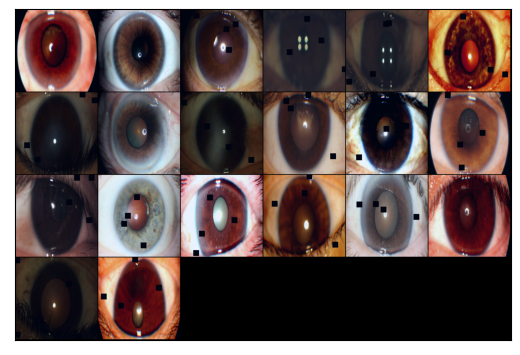

In [16]:
train_df_exploded_first_fold = train_df_exploded_per_fold[0]

# Create the image grid 
plt.rcParams["savefig.bbox"] = 'tight'  

# Grab a random sample of 20 images from the training set
random_df_samples = train_df_exploded_first_fold.iloc[np.random.randint(0, len(train_df_exploded_first_fold), size=20)]

images_to_display = []

# For each sample:
for _, sample_row in random_df_samples.iterrows():

    #  Read the image
    image_path = sample_row["image_path"]
    image_path_base = os.path.basename(image_path)
    image_path = os.path.join(dataset_images_root, image_path_base)

    #  Apply the data augmentation transforms
    source_image = Image.open(image_path)
    source_image_np = np.array(source_image)
    augmented = transform_train(image=source_image_np)
    image = augmented['image']
    
    # Renormalize the image into the range [0, 1], otherwise imshow will not display it correctly
    image = renormalize_image(image)

    # Add the image to the list of images to display
    images_to_display.append(image)

#  Display the image in the grid
grid = make_grid(images_to_display, nrow=6)
show_pytorch_image_grid(grid)


## Train model

### Helper function to get differential learning rate params

In [17]:
def get_differential_learning_rate_params(starting_lr, model_name, model, feature_extract):

    if not model_name.startswith("resnet"):
        raise ValueError(f"model_name must be 'resnet', but got {model_name}")
    
    fc_layer_names = [
        "fc.weight",
        "fc.bias"
    ]

    layer_names = []
    for idx, (name, param) in enumerate(model.named_parameters()):
        layer_names.append(name)
    layer_names.reverse()

    lr = starting_lr
    lr_mult = 0.5

    # placeholder
    parameters = []

    prev_group_name = layer_names[0].split('.')[0]

    # store params & learning rates
    for idx, name in enumerate(layer_names):

        # In feature extraction mode, ignore all parameters that are not in the last fc classifier layer.
        if feature_extract:
            if name not in fc_layer_names:
                continue

        # parameter group name
        cur_group_name = name.split('.')[0]

        # update learning rate
        if cur_group_name != prev_group_name:
            lr *= lr_mult
        prev_group_name = cur_group_name

        # display info
        print(f'{idx}: lr = {lr:.6f}, {name}')

        # append layer parameters
        parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad], 'lr':     lr}]

    return parameters

def prepare_model(model, freeze_unfreeze_all_base_weights_flag, feature_extract):


    # Freeze weights depending on what type of transfer learning
    if freeze_unfreeze_all_base_weights_flag:
        freeze_unfreeze_all_base_weights(model_name, model, freeze=feature_extract)
    else:
        unfreeze_final_layer_classifier_weights(model_name, model, only_unfreeze_classifier=feature_extract)

    if use_differential_learning_rate:
        if not freeze_unfreeze_all_base_weights_flag: 
            raise ValueError("If using differential learning rate, you must also set freeze_unfreeze_all_base_weights_flag to True")
        differential_learning_rate_params = get_differential_learning_rate_params(lr, model_name, model, feature_extract)
    else:
        # TODO: is this right?  If in feature_extract mode, should this only be the classifier weights?
        differential_learning_rate_params = model.parameters()

    # Send the model to GPU
    model = model.to(device)

    # Display trainable parameters
    print("Params to learn:")
    unfrozen_layers = []
    layer_names = []
    for name,param in model.named_parameters():
        layer_names.append(name)
        if param.requires_grad == True:
            print("\t", name, "unfrozen")
            unfrozen_layers.append(name)
        else:
            print("\t",name, " frozen")

    return model, differential_learning_rate_params, unfrozen_layers, layer_names


### Helper function to train model for fold

In [18]:
def train_model_for_fold(fold_index, training_loader, validation_loader):

    print(f"Training model for fold {fold_index}.  lr_step_size: {lr_step_size}")

    # Initialize the model for this run
    model = initialize_model(
        model_name, 
        num_classes, 
        final_dropout, 
        use_pretrained=True
    )

    model, differential_learning_rate_params, unfrozen_layers, layer_names = prepare_model(
        model, 
        freeze_unfreeze_all_base_weights_flag, 
        feature_extract
    )

    # Use BCEWithLogitsLoss since it already contains the sigmoid function, so 
    # it can take the raw logits as input
    criterion = torch.nn.BCEWithLogitsLoss()

    optimizer_ft = optim.AdamW(
        differential_learning_rate_params, 
        lr=lr,
        weight_decay=adamw_weight_decay # L2 regularization
    )

    # TODO: switch to cosine LR scheduler
    # Wrap the optimizer with a learning rate scheduler

    lr_scheduler = StepLR(optimizer_ft, step_size=lr_step_size, gamma=lr_gamma)
    
    wandb_config = {
        "learning_rate": lr,
        "dataset": "EyePacs1K",
        "epochs": num_epochs,
        "final_dropout": final_dropout,
        "feature_extract": feature_extract,
        "model_layers": f"{layer_names}", 
        "input_size": input_size,
        "model_name": model_name,
        "model_class": model.__class__.__name__,
        "batch_size": batch_size,
        "use_learning_rate_scheduler": use_learning_rate_scheduler,
        "lr_gamma": lr_gamma,
        "lr_step_size": lr_step_size,
        "unfrozen_layers": unfrozen_layers,
        "dataset_images_root": dataset_images_root,
        "use_differential_learning_rate": use_differential_learning_rate,
        "random_seed": random_seed,
        "train_transforms": [x.__class__.__name__ for x in transform_train.transforms],
        "validation_transforms": [x.__class__.__name__ for x in transform_validation_test.transforms],
        "criterion": criterion.__class__.__name__,
        "optimizer": optimizer_ft.__class__.__name__,
        "lr_scheduler": lr_scheduler.__class__.__name__,
        "percent_of_dataset_to_use": percent_of_dataset_to_use,
        "cutout_max_h_size": cutout_max_h_size, 
        "cutout_max_w_size": cutout_max_w_size,
        "cutout_num_holes": cutout_num_holes,
        "cutout_prob": cutout_prob,
        "adamw_weight_decay": adamw_weight_decay,
        "freeze_unfreeze_all_base_weights_flag": freeze_unfreeze_all_base_weights_flag,
        "add_regularization_augmentations": add_regularization_augmentations,
        "fold_index": fold_index,
        "num_folds": num_folds,
        "balance_labels_by_under_sampling": balance_labels_by_under_sampling,
        "len_training_df_exploded": len(train_df_exploded_per_fold[0]),
        "len_validation_df_exploded": len(validation_df_exploded_per_fold[0]),
    }

    wandb.init(
        # Use team
        entity="eyepi",
        # Set the project where this run will be logged
        project="YOUthEyePacs1K", 
        # Track hyperparameters and run metadata
        config=wandb_config
    )

    # Setup phases and dataloader dicts. 
    dataloaders_dict = {
        "train": training_loader,
        "val": validation_loader
    }
    phases=['train', 'val']

    # Train and evaluate
    model, _, _, _, best_validation_roc_auc = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        lr_scheduler,
        num_epochs=num_epochs, 
        phases=phases,
        device=device,
        is_inception=(model_name=="inception"),
        wandb_config=wandb_config,
    )

    wandb.finish()

    return model, best_validation_roc_auc


### Display model

In [19]:
display_model = initialize_model(
    model_name, 
    num_classes, 
    final_dropout, 
    use_pretrained=True
)
display_model


/opt/miniconda/miniconda3/envs/youth_eye_detection/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda/miniconda3/envs/youth_eye_detection/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train model on each fold

In [20]:

validation_roc_aucs = []

for fold_index in range(num_folds):
    
    training_loader = training_loader_per_fold[fold_index]
    validation_loader = validation_loader_per_fold[fold_index]
    
    model, best_validation_roc_auc = train_model_for_fold(
        fold_index, 
        training_loader, 
        validation_loader
    )

    print(f"Training complete for fold {fold_index}.  Best validation ROC AUC: {best_validation_roc_auc:.4f}.")
    validation_roc_aucs.append(best_validation_roc_auc)

    # Save the model
    model_save_name = f'{model_name}_fold_{fold_index}best_validation_roc_auc_{best_validation_roc_auc:.4f}.pth'
    model_save_path = os.path.join("saved_models", model_save_name)
    torch.save(model.state_dict(), model_save_path)
    print(f"Saved model to {model_save_path}")

average_validation_roc_auc = sum(validation_roc_aucs) / len(validation_roc_aucs)
print(f"Average validation ROC AUC accross {num_folds} folds: {average_validation_roc_auc:.4f}.")  



Training model for fold 0.  lr_step_size: 50
Params to learn:
	 conv1.weight  frozen
	 bn1.weight  frozen
	 bn1.bias  frozen
	 layer1.0.conv1.weight  frozen
	 layer1.0.bn1.weight  frozen
	 layer1.0.bn1.bias  frozen
	 layer1.0.conv2.weight  frozen
	 layer1.0.bn2.weight  frozen
	 layer1.0.bn2.bias  frozen
	 layer1.1.conv1.weight  frozen
	 layer1.1.bn1.weight  frozen
	 layer1.1.bn1.bias  frozen
	 layer1.1.conv2.weight  frozen
	 layer1.1.bn2.weight  frozen
	 layer1.1.bn2.bias  frozen
	 layer2.0.conv1.weight  frozen
	 layer2.0.bn1.weight  frozen
	 layer2.0.bn1.bias  frozen
	 layer2.0.conv2.weight  frozen
	 layer2.0.bn2.weight  frozen
	 layer2.0.bn2.bias  frozen
	 layer2.0.downsample.0.weight  frozen
	 layer2.0.downsample.1.weight  frozen
	 layer2.0.downsample.1.bias  frozen
	 layer2.1.conv1.weight  frozen
	 layer2.1.bn1.weight  frozen
	 layer2.1.bn1.bias  frozen
	 layer2.1.conv2.weight  frozen
	 layer2.1.bn2.weight  frozen
	 layer2.1.bn2.bias  frozen
	 layer3.0.conv1.weight  frozen
	 layer3

Epoch 0/199
----------


100%|██████████| 53/53 [00:07<00:00,  6.69it/s]


train Loss: 0.6667 F1: 0.7610 Acc: 0.6220 ROCAUC: 0.5407 Precision: 0.6299 Recall: 0.9608 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


val Loss: 0.6755 F1: 0.7413 Acc: 0.5889 ROCAUC: 0.5201 Precision: 0.5889 Recall: 1.0000 LR: [0.0001]
Epoch 1/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.63it/s]


train Loss: 0.6527 F1: 0.7679 Acc: 0.6298 ROCAUC: 0.5886 Precision: 0.6321 Recall: 0.9780 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


val Loss: 0.6697 F1: 0.7420 Acc: 0.5938 ROCAUC: 0.5666 Precision: 0.5927 Recall: 0.9918 LR: [0.0001]
Epoch 2/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.53it/s]


train Loss: 0.6482 F1: 0.7619 Acc: 0.6310 ROCAUC: 0.6269 Precision: 0.6392 Recall: 0.9427 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


val Loss: 0.6684 F1: 0.7420 Acc: 0.5938 ROCAUC: 0.5930 Precision: 0.5927 Recall: 0.9918 LR: [0.0001]
Epoch 3/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.44it/s]


train Loss: 0.6371 F1: 0.7624 Acc: 0.6310 ROCAUC: 0.6487 Precision: 0.6387 Recall: 0.9456 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.45it/s]


val Loss: 0.6637 F1: 0.7395 Acc: 0.5986 ROCAUC: 0.5967 Precision: 0.5985 Recall: 0.9673 LR: [0.0001]
Epoch 4/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.49it/s]


train Loss: 0.6382 F1: 0.7525 Acc: 0.6286 ROCAUC: 0.6531 Precision: 0.6457 Recall: 0.9016 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


val Loss: 0.6610 F1: 0.7159 Acc: 0.6298 ROCAUC: 0.6085 Precision: 0.6532 Recall: 0.7918 LR: [0.0001]
Epoch 5/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.74it/s]


train Loss: 0.6371 F1: 0.7561 Acc: 0.6370 ROCAUC: 0.6607 Precision: 0.6526 Recall: 0.8988 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


val Loss: 0.6598 F1: 0.7219 Acc: 0.6130 ROCAUC: 0.6081 Precision: 0.6257 Recall: 0.8531 LR: [0.0001]
Epoch 6/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.69it/s]


train Loss: 0.6249 F1: 0.7650 Acc: 0.6495 ROCAUC: 0.6817 Precision: 0.6593 Recall: 0.9112 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


val Loss: 0.6630 F1: 0.7019 Acc: 0.6202 ROCAUC: 0.6135 Precision: 0.6526 Recall: 0.7592 LR: [0.0001]
Epoch 7/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.61it/s]


train Loss: 0.6321 F1: 0.7579 Acc: 0.6411 ROCAUC: 0.6574 Precision: 0.6562 Recall: 0.8968 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


val Loss: 0.6567 F1: 0.7124 Acc: 0.6274 ROCAUC: 0.6245 Precision: 0.6531 Recall: 0.7837 LR: [0.0001]
Epoch 8/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.64it/s]


train Loss: 0.6316 F1: 0.7526 Acc: 0.6328 ROCAUC: 0.6688 Precision: 0.6509 Recall: 0.8921 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


val Loss: 0.6570 F1: 0.7334 Acc: 0.6226 ROCAUC: 0.6154 Precision: 0.6279 Recall: 0.8816 LR: [0.0001]
Epoch 9/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.63it/s]


train Loss: 0.6273 F1: 0.7545 Acc: 0.6358 ROCAUC: 0.6747 Precision: 0.6527 Recall: 0.8940 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


val Loss: 0.6579 F1: 0.7328 Acc: 0.6178 ROCAUC: 0.6138 Precision: 0.6229 Recall: 0.8898 LR: [0.0001]
Epoch 10/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.45it/s]


train Loss: 0.6167 F1: 0.7629 Acc: 0.6579 ROCAUC: 0.7005 Precision: 0.6740 Recall: 0.8787 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


val Loss: 0.6678 F1: 0.7437 Acc: 0.6106 ROCAUC: 0.6181 Precision: 0.6072 Recall: 0.9592 LR: [0.0001]
Epoch 11/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.54it/s]


train Loss: 0.6142 F1: 0.7597 Acc: 0.6537 ROCAUC: 0.6987 Precision: 0.6718 Recall: 0.8739 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.44it/s]


val Loss: 0.6628 F1: 0.7468 Acc: 0.6202 ROCAUC: 0.6240 Precision: 0.6148 Recall: 0.9510 LR: [0.0001]
Epoch 12/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.61it/s]


train Loss: 0.6151 F1: 0.7590 Acc: 0.6483 ROCAUC: 0.6891 Precision: 0.6648 Recall: 0.8844 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.55it/s]


val Loss: 0.6567 F1: 0.7443 Acc: 0.6250 ROCAUC: 0.6353 Precision: 0.6219 Recall: 0.9265 LR: [0.0001]
Epoch 13/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.41it/s]


train Loss: 0.6100 F1: 0.7669 Acc: 0.6633 ROCAUC: 0.7058 Precision: 0.6769 Recall: 0.8844 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


val Loss: 0.6623 F1: 0.7418 Acc: 0.6202 ROCAUC: 0.6295 Precision: 0.6185 Recall: 0.9265 LR: [0.0001]
Epoch 14/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.61it/s]


train Loss: 0.6122 F1: 0.7587 Acc: 0.6549 ROCAUC: 0.6955 Precision: 0.6749 Recall: 0.8663 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.28it/s]


val Loss: 0.6718 F1: 0.7476 Acc: 0.6154 ROCAUC: 0.6183 Precision: 0.6093 Recall: 0.9673 LR: [0.0001]
Epoch 15/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.61it/s]


train Loss: 0.6033 F1: 0.7668 Acc: 0.6657 ROCAUC: 0.7044 Precision: 0.6807 Recall: 0.8777 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


val Loss: 0.6691 F1: 0.7448 Acc: 0.6130 ROCAUC: 0.6281 Precision: 0.6088 Recall: 0.9592 LR: [0.0001]
Epoch 16/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.41it/s]


train Loss: 0.6059 F1: 0.7647 Acc: 0.6651 ROCAUC: 0.7066 Precision: 0.6827 Recall: 0.8691 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


val Loss: 0.6574 F1: 0.7310 Acc: 0.6178 ROCAUC: 0.6153 Precision: 0.6243 Recall: 0.8816 LR: [0.0001]
Epoch 17/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.66it/s]


train Loss: 0.6031 F1: 0.7650 Acc: 0.6657 ROCAUC: 0.7191 Precision: 0.6832 Recall: 0.8691 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.35it/s]


val Loss: 0.6636 F1: 0.7417 Acc: 0.6250 ROCAUC: 0.6251 Precision: 0.6240 Recall: 0.9143 LR: [0.0001]
Epoch 18/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.58it/s]


train Loss: 0.6107 F1: 0.7640 Acc: 0.6549 ROCAUC: 0.6966 Precision: 0.6681 Recall: 0.8921 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


val Loss: 0.6526 F1: 0.7166 Acc: 0.6274 ROCAUC: 0.6223 Precision: 0.6490 Recall: 0.8000 LR: [0.0001]
Epoch 19/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.52it/s]


train Loss: 0.6136 F1: 0.7559 Acc: 0.6519 ROCAUC: 0.6953 Precision: 0.6739 Recall: 0.8606 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.43it/s]


val Loss: 0.6898 F1: 0.7445 Acc: 0.6058 ROCAUC: 0.6225 Precision: 0.6020 Recall: 0.9755 LR: [0.0001]
Epoch 20/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.60it/s]


train Loss: 0.5932 F1: 0.7805 Acc: 0.6842 ROCAUC: 0.7276 Precision: 0.6909 Recall: 0.8968 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.34it/s]


val Loss: 0.6556 F1: 0.6929 Acc: 0.6058 ROCAUC: 0.6137 Precision: 0.6401 Recall: 0.7551 LR: [0.0001]
Epoch 21/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.58it/s]


train Loss: 0.6052 F1: 0.7679 Acc: 0.6734 ROCAUC: 0.7144 Precision: 0.6920 Recall: 0.8625 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


val Loss: 0.6686 F1: 0.7532 Acc: 0.6346 ROCAUC: 0.6296 Precision: 0.6253 Recall: 0.9469 LR: [0.0001]
Epoch 22/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.68it/s]


train Loss: 0.5990 F1: 0.7722 Acc: 0.6782 ROCAUC: 0.7068 Precision: 0.6935 Recall: 0.8711 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


val Loss: 0.6751 F1: 0.7445 Acc: 0.6106 ROCAUC: 0.6147 Precision: 0.6067 Recall: 0.9633 LR: [0.0001]
Epoch 23/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.67it/s]


train Loss: 0.6062 F1: 0.7616 Acc: 0.6627 ROCAUC: 0.7166 Precision: 0.6831 Recall: 0.8606 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


val Loss: 0.6797 F1: 0.7484 Acc: 0.6154 ROCAUC: 0.6097 Precision: 0.6087 Recall: 0.9714 LR: [0.0001]
Epoch 24/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.55it/s]


train Loss: 0.5914 F1: 0.7700 Acc: 0.6752 ROCAUC: 0.7243 Precision: 0.6918 Recall: 0.8682 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.37it/s]


val Loss: 0.6654 F1: 0.7418 Acc: 0.6202 ROCAUC: 0.6209 Precision: 0.6185 Recall: 0.9265 LR: [0.0001]
Epoch 25/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.65it/s]


train Loss: 0.5995 F1: 0.7650 Acc: 0.6740 ROCAUC: 0.7171 Precision: 0.6973 Recall: 0.8472 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.43it/s]


val Loss: 0.6764 F1: 0.7484 Acc: 0.6202 ROCAUC: 0.6272 Precision: 0.6136 Recall: 0.9592 LR: [0.0001]
Epoch 26/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.69it/s]


train Loss: 0.6009 F1: 0.7704 Acc: 0.6699 ROCAUC: 0.7185 Precision: 0.6824 Recall: 0.8844 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.45it/s]


val Loss: 0.6523 F1: 0.7231 Acc: 0.6226 ROCAUC: 0.6173 Precision: 0.6366 Recall: 0.8367 LR: [0.0001]
Epoch 27/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.68it/s]


train Loss: 0.5929 F1: 0.7750 Acc: 0.6812 ROCAUC: 0.7283 Precision: 0.6944 Recall: 0.8768 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.39it/s]


val Loss: 0.6514 F1: 0.7276 Acc: 0.6274 ROCAUC: 0.6199 Precision: 0.6389 Recall: 0.8449 LR: [0.0001]
Epoch 28/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.68it/s]


train Loss: 0.5783 F1: 0.7846 Acc: 0.6980 ROCAUC: 0.7500 Precision: 0.7088 Recall: 0.8787 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


val Loss: 0.6523 F1: 0.7517 Acc: 0.6490 ROCAUC: 0.6244 Precision: 0.6443 Recall: 0.9020 LR: [0.0001]
Epoch 29/199
----------


100%|██████████| 53/53 [00:07<00:00,  7.57it/s]


train Loss: 0.5991 F1: 0.7696 Acc: 0.6734 ROCAUC: 0.7180 Precision: 0.6893 Recall: 0.8711 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.45it/s]


val Loss: 0.6576 F1: 0.6569 Acc: 0.6058 ROCAUC: 0.6109 Precision: 0.6738 Recall: 0.6408 LR: [0.0001]
Epoch 30/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.69it/s]


train Loss: 0.6181 F1: 0.7367 Acc: 0.6400 ROCAUC: 0.7148 Precision: 0.6796 Recall: 0.8042 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.47it/s]


val Loss: 0.6477 F1: 0.7063 Acc: 0.6202 ROCAUC: 0.6266 Precision: 0.6485 Recall: 0.7755 LR: [0.0001]
Epoch 31/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.64it/s]


train Loss: 0.5969 F1: 0.7721 Acc: 0.6752 ROCAUC: 0.7190 Precision: 0.6886 Recall: 0.8787 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


val Loss: 0.6511 F1: 0.7326 Acc: 0.6298 ROCAUC: 0.6250 Precision: 0.6375 Recall: 0.8612 LR: [0.0001]
Epoch 32/199
----------


100%|██████████| 53/53 [00:06<00:00,  7.67it/s]


train Loss: 0.5925 F1: 0.7756 Acc: 0.6806 ROCAUC: 0.7293 Precision: 0.6924 Recall: 0.8816 LR: [0.0001]


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


val Loss: 0.6506 F1: 0.7193 Acc: 0.6154 ROCAUC: 0.6359 Precision: 0.6308 Recall: 0.8367 LR: [0.0001]
Epoch 33/199
----------


 23%|██▎       | 12/53 [00:01<00:05,  7.44it/s]

## Plot confusion matrix


In [ ]:
# cm = confusion_matrix(validation_labels_epoch, validation_preds_epoch)
# ConfusionMatrixDisplay(cm).plot()

## TODO: Display validation set correct and incorrect predictions 

This should give some clues on where the model is getting confused